In [ ]:
!nvidia-smi

Mon Aug  9 17:02:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [ ]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (json.dumps(projects[-305], indent=2))

{
  "id": 2106,
  "created_on": "2020-08-08 15:06:18",
  "title": "Fast NST for Videos (+ person segmentation) \ud83c\udfa5 + \u26a1\ud83d\udcbb + \ud83c\udfa8 = \u2764\ufe0f",
  "description": "Create NST videos and pick separate styles for the person in the video and for the background.",
  "tags": [
    "code",
    "tutorial",
    "video",
    "computer-vision",
    "style-transfer",
    "neural-style-transfer"
  ]
}


In [ ]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

2032 projects


,id,created_on,title,description,tags
0,1,2020-02-17 06:30:41,Machine Learning Basics,A practical set of notebooks on machine learni...,"[code, tutorial, keras, pytorch, tensorflow, d..."
1,2,2020-02-17 06:41:45,Deep Learning with Electronic Health Record (E...,A comprehensive look at recent machine learnin...,"[article, tutorial, deep-learning, health, ehr]"
2,3,2020-02-20 06:07:59,Automatic Parking Management using computer vi...,Detecting empty and parked spaces in car parki...,"[code, tutorial, video, python, machine-learni..."
3,4,2020-02-20 06:21:57,Easy street parking using region proposal netw...,Get a text on your phone whenever a nearby par...,"[code, tutorial, python, pytorch, machine-lear..."
4,5,2020-02-20 06:29:18,Deep Learning based parking management system ...,Fastai provides easy to use wrappers to quickl...,"[code, tutorial, fastai, deep-learning, parkin..."


In [ ]:
# Load tags (Auxilary dataset)
# this dataset has the aliases for our tags, and has parent-child relationships to suggest relevant parent tags
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tags.json"
tags = json.loads(urlopen(url).read())
tags_dict = {}
for item in tags:
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")

400 tags


In [ ]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag='question-answering'):
    print (json.dumps(tags_dict[tag], indent=2))

interactive(children=(Dropdown(description='tag', index=283, options=('3d', 'action-localization', 'action-rec…

In [ ]:
!pip install snorkel

     |████████████████████████████████| 145 kB 4.0 MB/s 
     |████████████████████████████████| 1.7 MB 38.8 MB/s 
     |████████████████████████████████| 3.8 MB 37.4 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=d5540f1fc443c9a157b41db5f490b410f4d160c86996e71df9057be6f83e7e7d
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.2
    Uninstalling networkx-2.6.2:
      Successfully uninstalled networkx-2.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires t

In [ ]:
from snorkel.labeling import labeling_function

@labeling_function()
def contains_tensorflow(text):
    condition = any(tag in text.lower() for tag in ("tensorflow", "tf"))
    return "tensorflow" if condition else None

In [ ]:
# Input
df['text'] = df.title + " " + df.description

In [ ]:

df.head()

,id,created_on,title,description,tags,text
0,1,2020-02-17 06:30:41,Machine Learning Basics,A practical set of notebooks on machine learni...,"[code, tutorial, keras, pytorch, tensorflow, d...",Machine Learning Basics A practical set of not...
1,2,2020-02-17 06:41:45,Deep Learning with Electronic Health Record (E...,A comprehensive look at recent machine learnin...,"[article, tutorial, deep-learning, health, ehr]",Deep Learning with Electronic Health Record (E...
2,3,2020-02-20 06:07:59,Automatic Parking Management using computer vi...,Detecting empty and parked spaces in car parki...,"[code, tutorial, video, python, machine-learni...",Automatic Parking Management using computer vi...
3,4,2020-02-20 06:21:57,Easy street parking using region proposal netw...,Get a text on your phone whenever a nearby par...,"[code, tutorial, python, pytorch, machine-lear...",Easy street parking using region proposal netw...
4,5,2020-02-20 06:29:18,Deep Learning based parking management system ...,Fastai provides easy to use wrappers to quickl...,"[code, tutorial, fastai, deep-learning, parkin...",Deep Learning based parking management system ...


In [ ]:
# filtering
def filter(l, include=[], exclude=[]):
    """Filter a list using inclusion and exclusion lists of items."""
    filtered = [item for item in l if item in include and item not in exclude]
    return filtered

In [ ]:
# Inclusion/exclusion criteria for tags
include = list(tags_dict.keys())
exclude = ['machine-learning', 'deep-learning',  'data-science',
           'neural-networks', 'python', 'r', 'visualization']

In [ ]:
# Filter tags for each project
df.tags = df.tags.apply(filter, include=include, exclude=exclude)
tags = Counter(itertools.chain.from_iterable(df.tags.values))

In [ ]:
@widgets.interact(min_tag_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_tag_freq=30):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_tag_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_tag_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(5))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-5:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(5))

interactive(children=(IntSlider(value=30, description='min_tag_freq', max=424), Output()), _dom_classes=('widg…

In [ ]:
# Filter tags that have fewer than <min_tag_freq> occurances
min_tag_freq = 30
tags_above_freq = Counter(tag for tag in tags.elements()
                          if tags[tag] >= min_tag_freq)
df.tags = df.tags.apply(filter, include=list(tags_above_freq.keys()))

In [ ]:
# Remove projects with no more remaining relevant tags
df = df[df.tags.map(len) > 0]
print (f"{len(df)} projects")

1444 projects


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text, lower=True, stem=False, 
               filters="[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]", 
               stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([porter.stem(word) for word in text.split(' ')])

    return text

In [ ]:
@widgets.interact(lower=True, stem=False)
def display_preprocessed_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    preprocessed_text = preprocess(text=text, lower=lower, stem=stem)
    print (preprocessed_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [ ]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(preprocess, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Machine Learning Basics A practical set of notebooks on machine learning basics, implemented in both TF2.0 + Keras and PyTorch.
machine learning basics practical set notebooks machine learning basics implemented tf2 0 keras pytorch


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

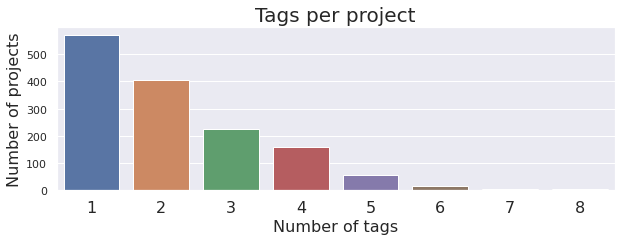

In [ ]:
# Number of tags per project
num_tags_per_project = [len(tags) for tags in df.tags]
num_tags, num_projects = zip(*Counter(num_tags_per_project).items())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(num_tags), list(num_projects))
plt.title("Tags per project", fontsize=20)
plt.xlabel("Number of tags", fontsize=16)
ax.set_xticklabels(range(1, len(num_tags)+1), rotation=0, fontsize=16)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

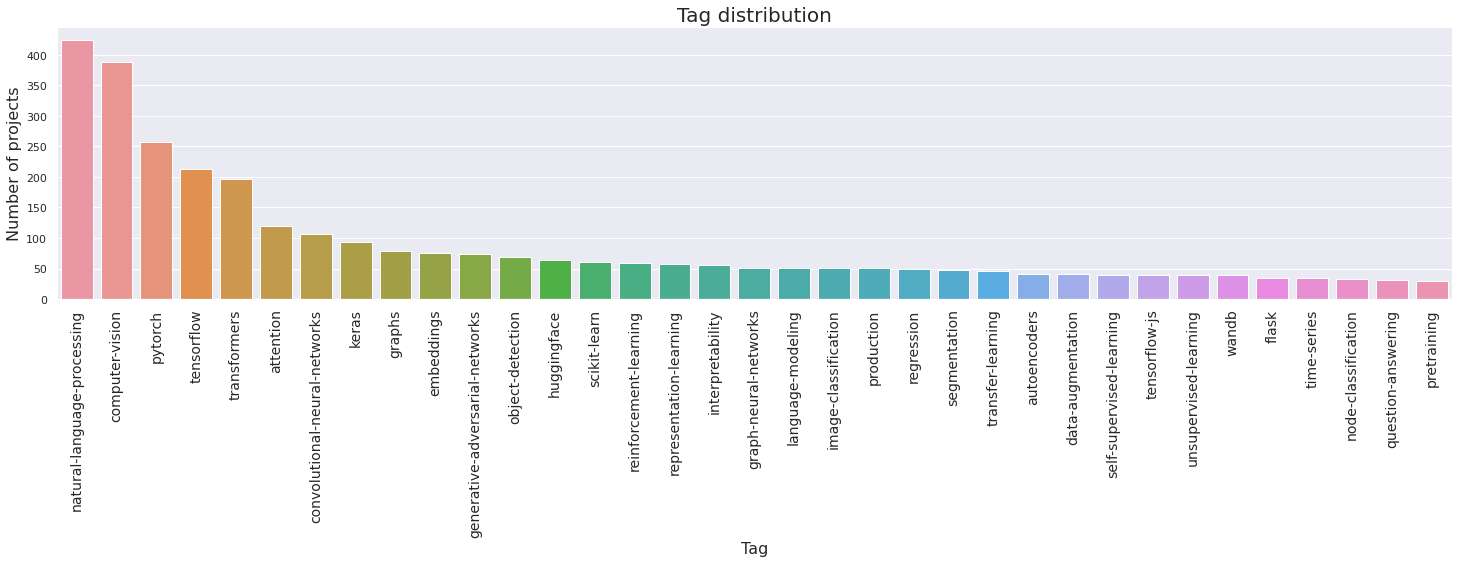

In [ ]:
# Distribution of tags
all_tags = list(itertools.chain.from_iterable(df.tags.values))
tags, tag_counts = zip(*Counter(all_tags).most_common())
plt.figure(figsize=(25, 5))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [ ]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="pytorch"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tags.apply(lambda tags: tag in tags)]
    text = subset.text.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=2, options=('natural-language-processing', 'computer-v…

In [ ]:
import numpy as np
import random

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [ ]:
label_encoder.class_to_index

{'attention': 0,
 'autoencoders': 1,
 'computer-vision': 2,
 'convolutional-neural-networks': 3,
 'data-augmentation': 4,
 'embeddings': 5,
 'flask': 6,
 'generative-adversarial-networks': 7,
 'graph-neural-networks': 8,
 'graphs': 9,
 'huggingface': 10,
 'image-classification': 11,
 'interpretability': 12,
 'keras': 13,
 'language-modeling': 14,
 'natural-language-processing': 15,
 'node-classification': 16,
 'object-detection': 17,
 'pretraining': 18,
 'production': 19,
 'pytorch': 20,
 'question-answering': 21,
 'regression': 22,
 'reinforcement-learning': 23,
 'representation-learning': 24,
 'scikit-learn': 25,
 'segmentation': 26,
 'self-supervised-learning': 27,
 'tensorflow': 28,
 'tensorflow-js': 29,
 'time-series': 30,
 'transfer-learning': 31,
 'transformers': 32,
 'unsupervised-learning': 33,
 'wandb': 34}

In [ ]:
# Sample
label_encoder.encode([["attention", "data-augmentation"]])

array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(1444, 35)


# Naive Split
our task is multi-label classification (an input can have many labels) which complicates the stratification process.

First, we'll naively split our dataset randomly and show the large deviations between the (adjusted) class distributions across the splits. We'll use scikit-learn's train_test_split function to do the splits.

In [ ]:
!pip install scikit-multilearn==0.2.0 -q

     |████████████████████████████████| 89 kB 3.9 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [ ]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [ ]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)

In [ ]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 1010 (0.70)
remaining: 434 (0.30)


In [ ]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1010 (0.70)
val: 217 (0.15)
test: 217 (0.15)


In [ ]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

counts

{'test_counts': Counter({'(0,)': 15,
          '(1,)': 8,
          '(10,)': 7,
          '(11,)': 8,
          '(12,)': 9,
          '(13,)': 12,
          '(14,)': 6,
          '(15,)': 66,
          '(16,)': 5,
          '(17,)': 11,
          '(18,)': 3,
          '(19,)': 5,
          '(2,)': 60,
          '(20,)': 41,
          '(21,)': 4,
          '(22,)': 2,
          '(23,)': 10,
          '(24,)': 10,
          '(25,)': 11,
          '(26,)': 10,
          '(27,)': 2,
          '(28,)': 26,
          '(29,)': 6,
          '(3,)': 19,
          '(30,)': 4,
          '(31,)': 5,
          '(32,)': 24,
          '(33,)': 4,
          '(34,)': 5,
          '(4,)': 3,
          '(5,)': 8,
          '(6,)': 7,
          '(7,)': 11,
          '(8,)': 11,
          '(9,)': 15}),
 'train_counts': Counter({'(0,)': 79,
          '(1,)': 28,
          '(10,)': 45,
          '(11,)': 32,
          '(12,)': 40,
          '(13,)': 66,
          '(14,)': 35,
          '(15,)': 289,
        

In [ ]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(2,)","(26,)","(15,)","(5,)","(20,)","(32,)","(0,)","(28,)","(27,)","(17,)","(25,)","(1,)","(34,)","(3,)","(31,)","(11,)","(19,)","(10,)","(18,)","(13,)","(16,)","(9,)","(21,)","(6,)","(23,)","(33,)","(14,)","(29,)","(22,)","(30,)","(4,)","(24,)","(12,)","(8,)","(7,)"
train,271,33,289,58,184,134,79,158,30,46,43,28,28,69,32,32,40,45,24,66,24,54,23,20,39,29,35,30,42,25,30,41,40,35,49
val,57,5,69,9,33,38,26,29,8,12,6,5,6,18,9,11,6,12,3,15,4,9,5,7,10,6,10,4,5,5,8,6,6,5,13
test,60,10,66,8,41,24,15,26,2,11,11,8,5,19,5,8,5,7,3,12,5,15,4,7,10,4,6,6,2,4,3,10,9,11,11


It's hard to compare these because our train and test proportions are different. Let's see what the distribution looks like once we balance it out. What do we need to multiply our test ratio by so that we have the same amount as our train ratio?

$$ \alpha * N_{test} = N_{train} $$

$$ \alpha = \frac{N_{train}}{N_{test}} $$

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,"(2,)","(26,)","(15,)","(5,)","(20,)","(32,)","(0,)","(28,)","(27,)","(17,)","(25,)","(1,)","(34,)","(3,)","(31,)","(11,)","(19,)","(10,)","(18,)","(13,)","(16,)","(9,)","(21,)","(6,)","(23,)","(33,)","(14,)","(29,)","(22,)","(30,)","(4,)","(24,)","(12,)","(8,)","(7,)"
train,271,33,289,58,184,134,79,158,30,46,43,28,28,69,32,32,40,45,24,66,24,54,23,20,39,29,35,30,42,25,30,41,40,35,49
val,266,23,322,42,154,177,121,135,37,56,28,23,28,84,42,51,28,56,14,70,18,42,23,32,46,28,46,18,23,23,37,28,28,23,60
test,280,46,308,37,191,112,70,121,9,51,51,37,23,88,23,37,23,32,14,56,23,70,18,32,46,18,28,28,9,18,14,46,42,51,51


We can see how much deviance there is in our naive data splits by computing the standard deviation of each split's class counts from the mean (ideal split).

$ \sigma = \sqrt{\frac{(x - \bar{x})^2}{N}} $

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

8.644273732900697

#Stratified split
Now we'll apply iterative stratification via the skmultilearn library, which essentially splits each input into subsets (where each label is considered individually) and then it distributes the samples starting with fewest "positive" samples and working up to the inputs that have the most labels.

In [ ]:
from skmultilearn.model_selection import IterativeStratification

In [ ]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [ ]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.encode(y)

In [ ]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1023 (0.71)
val: 218 (0.15)
test: 203 (0.14)


In [ ]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(15,)","(7,)","(2,)","(1,)","(20,)","(4,)","(8,)","(9,)","(0,)","(32,)","(31,)","(5,)","(14,)","(13,)","(28,)","(27,)","(33,)","(19,)","(29,)","(3,)","(11,)","(17,)","(18,)","(25,)","(30,)","(23,)","(12,)","(10,)","(21,)","(34,)","(22,)","(26,)","(6,)","(24,)","(16,)"
train,297,51,272,29,181,29,36,55,84,142,31,52,42,65,149,28,27,36,28,74,37,51,26,42,24,41,38,49,27,28,34,34,24,42,24
val,298,46,270,37,177,28,46,56,60,121,60,56,23,56,149,28,28,32,28,74,28,51,9,42,23,42,42,37,14,28,32,28,28,23,9
test,294,56,270,18,182,28,23,51,107,130,9,51,18,74,149,28,28,37,28,74,37,32,9,42,23,42,37,32,9,23,37,37,18,46,32


In [ ]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

4.878424991639657

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
train_df.head()

,text,tags
0,medacy medical text mining information extract...,[natural-language-processing]
1,pytorch tutorial deep learning researchers rep...,"[autoencoders, computer-vision, generative-adv..."
2,deltapy tabular data augmentation feature engi...,[data-augmentation]
3,graph convolution structured documents convert...,"[computer-vision, graph-neural-networks, graphs]"
4,illustrated bert elmo co nlp cracked transfer ...,"[attention, embeddings, language-modeling, nat..."


In [ ]:
!python -m pip install --upgrade pip
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.6 -q --use-feature=2020-resolver

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 380 kB 5.4 MB/s 
     |████████████████████████████████| 769 kB 35.1 MB/s 
     |████████████████████████████████| 1.2 MB 26.6 MB/s 
     |████████████████████████████████| 3.0 MB 38.6 MB/s 
     |████████████████████████████████| 895 kB 42.0 MB/s 
     |████████████████████████████████| 144 kB 5.2 MB/s 
     |████████████████████████████████| 6.7 MB 31.3 MB/s 


In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
# Load tokenizer and transformers
substituion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [ ]:
augmentated_text = substituion.augment(text)
print(augmentated_text)

performs probability comparison using variational sets and gans.


In [ ]:
# Insertions
augmentated_text = insertion.augment(text)
print(augmentated_text)

using conditional resolution image generation technique using multiple variational autoencoders and gans.


A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases from our auxiliary data. We'll use Snorkel's transformation functions to easily achieve this.

In [ ]:
import inflect
from snorkel.augmentation import transformation_function
inflect = inflect.engine()

In [ ]:
# Inflect
print (inflect.singular_noun("graphs"))
print (inflect.singular_noun("graph"))
print (inflect.plural_noun("graph"))
print (inflect.plural_noun("graphs"))

graph
False
graphs
graphss


In [ ]:
def replace_dash(x):
    return x.replace("-", " ")

In [ ]:
flat_tags_dict = {}
for tag, info in tags_dict.items():
    tag = tag.replace("-", " ")
    aliases = list(map(replace_dash, info["aliases"]))
    if len(aliases):
        flat_tags_dict[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flat_tags_dict[alias] = _aliases

In [ ]:
# Tags that could be singular or plural
can_be_singular = [
    'animations',
    'cartoons',
    'autoencoders',
    'conditional random fields',
    'convolutional neural networks',
    'databases',
    'deep q networks',
    'gated recurrent units',
    'gaussian processes',
    'generative adversarial networks',
    'graph convolutional networks',
    'graph neural networks',
    'k nearest neighbors',
    'learning rates',
    'multilayer perceptrons',
    'outliers',
    'pos',
    'quasi recurrent neural networks',
    'recommendation systems',
    'recurrent neural networks',
    'streaming data',
    'data streams',
    'support vector machines',
    'variational autoencoders']
can_be_plural = [
    'annotation',
    'data annotation',
    'continuous integration',
    'continuous deployment',
    'crf',
    'conversational ai',
    'chatbot',
    'cnn',
    'db',
    'dqn',
    'expectation maximization',
    'fine tuning',
    'finetuning',
    'finetune',
    'gru',
    'gan',
    'gcn',
    'gnn',
    'hyperparameter optimization',
    'hyperparameter tuning',
    'image generation',
    'inference',
    'prediction',
    'knn',
    'knowledge base',
    'language modeling',
    'latent dirichlet allocation',
    'lstm',
    'machine translation',
    'model compression',
    'compression',
    'perceptron',
    'mlp',
    'optical character recognition',
    'outlier detection',
    'pos tagging',
    'pca',
    'qrnn',
    'rnn',
    'segmentation',
    'image segmentation',
    'spatial temporal cnn',
    'data streaming',
    'svm',
    'tabular',
    'temporal cnn',
    'tcnn',
    'vae',
    'vqa',
    'visualization',
    'data visualization']

In [ ]:
# Add to flattened dict
for tag in can_be_singular:
    flat_tags_dict[inflect.singular_noun(tag)] = flat_tags_dict[tag]
for tag in can_be_plural:
    flat_tags_dict[inflect.plural_noun(tag)] = flat_tags_dict[tag]

In [ ]:
print (flat_tags_dict["gan"])
print (flat_tags_dict["gans"])
print (flat_tags_dict["generative adversarial network"])
print (flat_tags_dict["generative adversarial networks"])

['generative adversarial networks']
['generative adversarial networks']
['gan']
['gan']


In [ ]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [ ]:
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [ ]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [ ]:
@transformation_function()
def swap_aliases(x):
    """ Swap ML keywords with their aliases"""
    # Find all matches
    matches = []
    for i, tag in enumerate(flat_tags_dict):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flat_tags_dict[tag])}{x.text[match.end():]}"
    
    return x

In [ ]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey rl nlp tasks
survey rl nlp tasks


In [ ]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


Now we'll define a [augmentation policy](https://snorkel.readthedocs.io/en/v0.9.1/packages/augmentation.html) to apply our transformation functions with certain rules (how many samples to generate, whether to keep the original data point, etc.)

In [ ]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [ ]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 1023/1023 [00:23<00:00, 43.63it/s]


,text,tags
0,medacy medical text mining information extract...,[natural-language-processing]
1,pytorch tutorial deep learning researchers rep...,"[autoencoders, computer-vision, generative-adv..."
1,pytorch tutorial dl researchers repository pro...,"[autoencoders, computer-vision, generative-adv..."
2,deltapy tabular data augmentation feature engi...,[data-augmentation]
2,deltapy table augmentation feature engineering,[data-augmentation]


In [ ]:
len(train_df), len(train_df_augmented)

(1023, 2037)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

In [ ]:
def set_seeds(seed=1234):
    """Set seed for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
def get_data_splits(df, train_size=0.7):
    X = df.text.to_numpy()
    y = df.tags

    # Binarize y
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.encode(y)

    # Split
    X_train, X_, y_train, y_ = iterative_train_test_split(X, y, train_size=train_size)

    X_val, X_test, y_val, y_test = iterative_train_test_split(X_, y_, train_size=0.5)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step"""
        self.model.train()
        loss = 0.0

        for i, batch in enumerate(dataloader):
            batch = [item.to(self.device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()
            z = self.model(inputs)
            J = self.loss_fn(z, targets)
            J.backward()
            self.optimizer.step()

            loss += (J.detach().item() - loss) / (i+1)

        return loss

    def eval_step(self, dataloader):
        """Validation step"""
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                batch = [item.to(self.device) for item in batch]
                inputs, y_true = batch[:-1], batch[-1]

                z = self.model(inputs)
                J = self.loss_fn(z, y_true).item()

                loss += (J-loss) / (i+1)

                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """prediction step"""
        self.model.eval()
        y_probs = []

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                y_probs.extend(y_prob)

            return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)

            self.scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience

            else:
                _patience -= 1

            if not _patience:
                print("Stopping Early")
                break

            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
            
        return best_model

In [ ]:
set_seeds()

In [ ]:
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
print(label_encoder)
print(label_encoder.classes)

<LabelEncoder(num_classes=35)>
['attention', 'autoencoders', 'computer-vision', 'convolutional-neural-networks', 'data-augmentation', 'embeddings', 'flask', 'generative-adversarial-networks', 'graph-neural-networks', 'graphs', 'huggingface', 'image-classification', 'interpretability', 'keras', 'language-modeling', 'natural-language-processing', 'node-classification', 'object-detection', 'pretraining', 'production', 'pytorch', 'question-answering', 'regression', 'reinforcement-learning', 'representation-learning', 'scikit-learn', 'segmentation', 'self-supervised-learning', 'tensorflow', 'tensorflow-js', 'time-series', 'transfer-learning', 'transformers', 'unsupervised-learning', 'wandb']


In [ ]:
# random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(y_test), len(label_encoder.classes)))
print(y_pred.shape)
print(y_pred[:5])

(216, 35)
[[1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1]
 [1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0]
 [1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1]
 [0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0]
 [0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0]]


In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"Precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "Precision": 0.12961260880905734,
  "recall": 0.4811529933481153,
  "f1": 0.18463801609050298
}


In [ ]:
# percentage of 1s
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(label_encoder.classes))
print(tag_p)

0.062253875157100964


In [ ]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(label_encoder.classes)),
    p=[1-tag_p, tag_p])

In [ ]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(label_encoder.classes))

0.06164021164021164

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.1652981006079548,
  "recall": 0.08425720620842572,
  "f1": 0.1004113184620565
}


# Rule Based

In [ ]:
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Restrict to relevant tags
print (len(tags_dict))
tags_dict = {tag: tags_dict[tag] for tag in label_encoder.classes}
print (len(tags_dict))

400
35


In [ ]:
# Map aliases
aliases = {}
for tag, values in tags_dict.items():
    aliases[preprocess(tag)] = tag
    for alias in values["aliases"]:
        aliases[preprocess(alias)] = tag
aliases

{'ae': 'autoencoders',
 'attention': 'attention',
 'autoencoders': 'autoencoders',
 'cnn': 'convolutional-neural-networks',
 'computer vision': 'computer-vision',
 'convolutional neural networks': 'convolutional-neural-networks',
 'cv': 'computer-vision',
 'data augmentation': 'data-augmentation',
 'embeddings': 'embeddings',
 'flask': 'flask',
 'gan': 'generative-adversarial-networks',
 'generative adversarial networks': 'generative-adversarial-networks',
 'gnn': 'graph-neural-networks',
 'graph neural networks': 'graph-neural-networks',
 'graphs': 'graphs',
 'huggingface': 'huggingface',
 'image classification': 'image-classification',
 'image segmentation': 'segmentation',
 'interpretability': 'interpretability',
 'keras': 'keras',
 'language modeling': 'language-modeling',
 'lm': 'language-modeling',
 'natural language processing': 'natural-language-processing',
 'nlp': 'natural-language-processing',
 'nlproc': 'natural-language-processing',
 'node classification': 'node-classifica

In [ ]:
def get_classes(text, aliases, tags_dict):
    """If a token matches an alias,
    then add the corresponding tag
    class (and parent tags if any)."""
    classes = []
    for alias, tag in aliases.items():
        if alias in text:
            classes.append(tag)
            for parent in tags_dict[tag]["parents"]:
                classes.append(parent)
    return list(set(classes))

In [ ]:
# Sample
text = "This project extends gans for data augmentation specifically for object detection tasks."
get_classes(text=preprocess(text), aliases=aliases, tags_dict=tags_dict)

['generative-adversarial-networks',
 'object-detection',
 'computer-vision',
 'data-augmentation']

In [ ]:
# Prediction
y_pred = []
for text in X_test:
    classes = get_classes(text, aliases, tags_dict)
    y_pred.append(classes)

In [ ]:
# Encode labels
y_pred = label_encoder.encode(y_pred)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9208860988874386,
  "recall": 0.3991130820399113,
  "f1": 0.5301128625077306
}


In [ ]:
label_encoder.decode(y_pred)

[[],
 ['natural-language-processing', 'pytorch'],
 ['production', 'tensorflow'],
 [],
 [],
 ['computer-vision', 'segmentation'],
 [],
 ['self-supervised-learning'],
 [],
 ['computer-vision', 'flask'],
 ['reinforcement-learning'],
 ['generative-adversarial-networks'],
 ['natural-language-processing'],
 ['tensorflow'],
 [],
 ['huggingface', 'transformers'],
 ['generative-adversarial-networks', 'pytorch'],
 [],
 ['scikit-learn'],
 ['attention', 'transformers'],
 ['regression'],
 ['pytorch'],
 ['attention'],
 ['computer-vision', 'object-detection', 'tensorflow'],
 ['production'],
 ['tensorflow'],
 [],
 [],
 [],
 ['computer-vision', 'pytorch', 'transformers'],
 ['reinforcement-learning'],
 [],
 [],
 [],
 [],
 ['keras', 'tensorflow'],
 ['convolutional-neural-networks'],
 ['graph-neural-networks'],
 [],
 ['autoencoders'],
 ['pytorch'],
 ['scikit-learn'],
 ['tensorflow'],
 ['computer-vision', 'pytorch'],
 ['pytorch', 'tensorflow'],
 ['time-series'],
 ['computer-vision', 'object-detection'],
 [

In [ ]:
print (aliases[preprocess('gan')])
# print (aliases[preprocess('gans')]) # this won't find any match
print (aliases[preprocess('generative adversarial networks')])
# print (aliases[preprocess('generative adversarial network')]) # this won't find any match

generative-adversarial-networks
generative-adversarial-networks


In [ ]:
print (porter.stem("democracy"))
print (porter.stem("democracies"))

democraci
democraci


In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Map aliases
aliases = {}
for tag, values in tags_dict.items():
    aliases[preprocess(tag, stem=True)] = tag
    for alias in values['aliases']:
        aliases[preprocess(alias, stem=True)] = tag
aliases

{'ae': 'autoencoders',
 'attent': 'attention',
 'autoencod': 'autoencoders',
 'cnn': 'convolutional-neural-networks',
 'comput vision': 'computer-vision',
 'convolut neural network': 'convolutional-neural-networks',
 'cv': 'computer-vision',
 'data augment': 'data-augmentation',
 'embed': 'embeddings',
 'flask': 'flask',
 'gan': 'generative-adversarial-networks',
 'gener adversari network': 'generative-adversarial-networks',
 'gnn': 'graph-neural-networks',
 'graph': 'graphs',
 'graph neural network': 'graph-neural-networks',
 'huggingfac': 'huggingface',
 'imag classif': 'image-classification',
 'imag segment': 'segmentation',
 'interpret': 'interpretability',
 'kera': 'keras',
 'languag model': 'language-modeling',
 'lm': 'language-modeling',
 'natur languag process': 'natural-language-processing',
 'nlp': 'natural-language-processing',
 'nlproc': 'natural-language-processing',
 'node classif': 'node-classification',
 'object detect': 'object-detection',
 'pre train': 'pretraining',


In [ ]:
# Checks (we will write proper tests soon)
print (aliases[preprocess('gan', stem=True)])
print (aliases[preprocess('gans', stem=True)])
print (aliases[preprocess('generative adversarial network', stem=True)])
print (aliases[preprocess('generative adversarial networks', stem=True)])

generative-adversarial-networks
generative-adversarial-networks
generative-adversarial-networks
generative-adversarial-networks


In [ ]:
# Sample
text = "This project extends gans for data augmentation specifically for object detection tasks."
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

['generative-adversarial-networks',
 'object-detection',
 'computer-vision',
 'data-augmentation']

In [ ]:
# Prediction
y_pred = []
for text in X_test:
    classes = get_classes(text, aliases, tags_dict)
    y_pred.append(classes)

In [ ]:
# Encode Labels
y_pred = label_encoder.encode(y_pred)

In [ ]:
# Evaluation
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.9272452269216195,
  "recall": 0.49230769230769234,
  "f1": 0.6123374537258598
}


In [ ]:
# Infer
text = "Transfer learning with transformers for self-supervised learning"
print (preprocess(text, stem=True))
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

transfer learn transform self supervis learn


['transfer-learning', 'self-supervised-learning', 'transformers']

In [ ]:
# Infer
text = "Transfer learning with BERT for self-supervised learning"
print (preprocess(text, stem=True))
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

transfer learn bert self supervis learn


['transfer-learning', 'self-supervised-learning']

# ML Model (TF-IDF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
set_seeds()

In [ ]:
# get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# tf-idf
vectorizer = TfidfVectorizer()
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print(X_train.shape)
print(X_train[0])

medaci medic text mine inform extract spaci
(1023, 2664)
  (0, 2201)	0.40524073611189587
  (0, 867)	0.3194838856178571
  (0, 1220)	0.32577466363917534
  (0, 1499)	0.41727454451144624
  (0, 2382)	0.2469719456163559
  (0, 1471)	0.40524073611189587
  (0, 1468)	0.47775267611339706


In [ ]:
def fit_and_evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}


In [ ]:
# Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))
performance["k-nearest-neighbors"] = fit_and_evaluate(
    KNeighborsClassifier())
performance["random-forest"] = fit_and_evaluate(
    RandomForestClassifier(n_jobs=-1))
performance["gradient-boosting-machine"] = fit_and_evaluate(OneVsRestClassifier(
    GradientBoostingClassifier()))
performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))
print (json.dumps(performance, indent=2))

{
  "logistic-regression": {
    "precision": 0.6823725055432373,
    "recall": 0.21729490022172948,
    "f1": 0.3209531528348282
  },
  "k-nearest-neighbors": {
    "precision": 0.745187034701,
    "recall": 0.4811529933481153,
    "f1": 0.5701241735887392
  },
  "random-forest": {
    "precision": 0.7855303626350048,
    "recall": 0.35476718403547675,
    "f1": 0.47493517277013414
  },
  "gradient-boosting-machine": {
    "precision": 0.8492839095954727,
    "recall": 0.5898004434589801,
    "f1": 0.684042697310942
  },
  "support-vector-machine": {
    "precision": 0.84035330104759,
    "recall": 0.5099778270509978,
    "f1": 0.6191374381298343
  }
}


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
set_seeds()

In [ ]:
processed_df = df.copy()
processed_df.text = processed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(processed_df)
X_test_raw = X_test

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


In [ ]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, pad_token="<PAD", 
                 oov_token="<UNK>", token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v:k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(' ') for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]
                ))
            sequences.append(np.array(sequence))

        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text =  []
            for index in sequence:
                text.append(self.index_to_token.get(
                    index, self.oov_token
                ))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as  fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [ ]:
# tokenize
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts=X_train)

In [ ]:
vocab_size = len(tokenizer)

print(tokenizer)

<Tokenizer(num_tokens=39)>


In [ ]:
tokenizer.token_to_index

{' ': 2,
 '0': 30,
 '1': 31,
 '2': 26,
 '3': 32,
 '4': 36,
 '5': 34,
 '6': 37,
 '7': 38,
 '8': 35,
 '9': 33,
 '<PAD': 0,
 '<UNK>': 1,
 'a': 7,
 'b': 20,
 'c': 12,
 'd': 14,
 'e': 3,
 'f': 19,
 'g': 15,
 'h': 18,
 'i': 4,
 'j': 27,
 'k': 23,
 'l': 11,
 'm': 16,
 'n': 5,
 'o': 10,
 'p': 13,
 'q': 29,
 'r': 8,
 's': 9,
 't': 6,
 'u': 17,
 'v': 22,
 'w': 24,
 'x': 25,
 'y': 21,
 'z': 28}

In [ ]:
# Convert texts to sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → medacy medical text mining information extraction spacy
  (tokenized) → [16  3 14  7 12 21  2 16  3 14  4 12  7 11  2  6  3 25  6  2 16  4  5  4
  5 15  2  4  5 19 10  8 16  7  6  4 10  5  2  3 25  6  8  7 12  6  4 10
  5  2  9 13  7 12 21]


In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39  39],
class weights: {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564, 34: 0.02564102564102564

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [ ]:
class CNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # pad inputs
        X = pad_sequences(sequences=X, max_seq_len=self.max_filter_size)

        X = torch.LongTensor(X.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [ ]:
# Create datasets
filter_sizes = list(range(1, 11))
train_dataset = CNNTextDataset(
    X=X_train, y=y_train, max_filter_size=max(filter_sizes))
val_dataset = CNNTextDataset(
    X=X_val, y=y_val, max_filter_size=max(filter_sizes))
test_dataset = CNNTextDataset(
    X=X_test, y=y_test, max_filter_size=max(filter_sizes))
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Data splits:
  Train dataset:<Dataset(N=1023)>
  Val dataset: <Dataset(N=205)>
  Test dataset: <Dataset(N=216)>
Sample point:
  X: [16  3 14  7 12 21  2 16  3 14  4 12  7 11  2  6  3 25  6  2 16  4  5  4
  5 15  2  4  5 19 10  8 16  7  6  4 10  5  2  3 25  6  8  7 12  6  4 10
  5  2  9 13  7 12 21]
  y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [64, 185]
  y: [64, 35]


In [ ]:
embedding_dim = 128
num_filters = 128
hidden_dim = 128
dropout_p = 0.5

In [ ]:
m = nn.Conv1d(16, 33, 2, stride=1)
input = torch.randn(1, 16, 50)
output = m(input)
output.shape

torch.Size([1, 33, 49])

In [ ]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes, 
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(
            embedding_dim=embedding_dim, num_embeddings=vocab_size,
            padding_idx=padding_idx
        )

        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):
        x_in, = inputs
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2) # (N, channels, seq_length)
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # SAME padding
            padding_left = int(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))
            
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))

            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # concat
        z = torch.cat(z, 1)

        # FC
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [ ]:
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes
)
model = model.to(device)
print(model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (5): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (6): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,))
    (8): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (9): Conv1d(128, 128, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
)>


In [ ]:
# Arguments
lr = 2e-4
num_epochs = 200
patience = 10


In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00593, val_loss: 0.00333, lr: 2.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.00395, val_loss: 0.00323, lr: 2.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.00357, val_loss: 0.00301, lr: 2.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.00331, val_loss: 0.00296, lr: 2.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.00319, val_loss: 0.00289, lr: 2.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.00307, val_loss: 0.00285, lr: 2.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.00288, val_loss: 0.00279, lr: 2.00E-04, _patience: 10
Epoch: 8 | train_loss: 0.00284, val_loss: 0.00273, lr: 2.00E-04, _patience: 10
Epoch: 9 | train_loss: 0.00274, val_loss: 0.00265, lr: 2.00E-04, _patience: 10
Epoch: 10 | train_loss: 0.00263, val_loss: 0.00261, lr: 2.00E-04, _patience: 10
Epoch: 11 | train_loss: 0.00252, val_loss: 0.00250, lr: 2.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.00242, val_loss: 0.00241, lr: 2.00E-04, _patience: 10
Epoch: 13 | train_loss: 0.00232, val_loss: 0.0023

In [ ]:
from pathlib import Path
from sklearn.metrics import precision_recall_curve

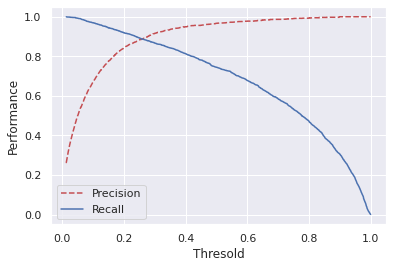

In [ ]:
# thresold PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.xlabel("Thresold")
plt.ylabel("Performance")
plt.legend(loc="best")

In [ ]:
# Determining the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.29723603

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.7774170799471126,
  "recall": 0.5521064301552107,
  "f1": 0.6231184058987846
}


In [ ]:
# Save artifacts
# dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
tokenizer.save(fp=Path(dir, "tokenizer.json"))
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "preformance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
# load artifacts
dir = Path("/content/drive/MyDrive/Projects/cnn")
device = torch.device("cpu")
tokenizer = Tokenizer.load(fp=Path(dir, "tokenizer.json"))
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes
)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (5): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (6): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,))
    (8): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (9): Conv1d(128, 128, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = np.array(tokenizer.texts_to_sequences([preprocess(text)]))
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]]*len(X))])
dataset = CNNTextDataset(
    X=X, y=y_filler, max_filter_size=max(filter_sizes))
dataloader = dataset.create_dataloader(
    batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

[['self-supervised-learning', 'transfer-learning']]

# RNN

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
X_test_raw = X_test

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


In [ ]:
# Tokenize
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(tokenizer)
print ("X tokenizer:\n"
    f"  {tokenizer}")

X tokenizer:
  <Tokenizer(num_tokens=39)>


In [ ]:
tokenizer.token_to_index

{' ': 2,
 '0': 30,
 '1': 31,
 '2': 26,
 '3': 32,
 '4': 36,
 '5': 34,
 '6': 37,
 '7': 38,
 '8': 35,
 '9': 33,
 '<PAD': 0,
 '<UNK>': 1,
 'a': 7,
 'b': 20,
 'c': 12,
 'd': 14,
 'e': 3,
 'f': 19,
 'g': 15,
 'h': 18,
 'i': 4,
 'j': 27,
 'k': 23,
 'l': 11,
 'm': 16,
 'n': 5,
 'o': 10,
 'p': 13,
 'q': 29,
 'r': 8,
 's': 9,
 't': 6,
 'u': 17,
 'v': 22,
 'w': 24,
 'x': 25,
 'y': 21,
 'z': 28}

In [ ]:
# Convert texts to sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → medacy medical text mining information extraction spacy
  (tokenized) → [16  3 14  7 12 21  2 16  3 14  4 12  7 11  2  6  3 25  6  2 16  4  5  4
  5 15  2  4  5 19 10  8 16  7  6  4 10  5  2  3 25  6  8  7 12  6  4 10
  5  2  9 13  7 12 21]


In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39  39],
class weights: {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564, 34: 0.02564102564102564

In [ ]:
class RNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, len(X), y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        seq_lens = batch[:, 1]
        y = np.stack(batch[:, 2], axis=0)

        # Pad inputs
        X = pad_sequences(sequences=X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, seq_lens, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [ ]:
# Create datasets
train_dataset = RNNTextDataset(
    X=X_train, y=y_train)
val_dataset = RNNTextDataset(
    X=X_val, y=y_val)
test_dataset = RNNTextDataset(
    X=X_test, y=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  seq_len: {train_dataset[0][1]}\n"
    f"  y: {train_dataset[0][2]}")

Data splits:
  Train dataset:<Dataset(N=1023)>
  Val dataset: <Dataset(N=205)>
  Test dataset: <Dataset(N=216)>
Sample point:
  X: [16  3 14  7 12 21  2 16  3 14  4 12  7 11  2  6  3 25  6  2 16  4  5  4
  5 15  2  4  5 19 10  8 16  7  6  4 10  5  2  3 25  6  8  7 12  6  4 10
  5  2  9 13  7 12 21]
  seq_len: 55
  y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_seq_lens, batch_y = next(iter(train_dataloader))
print (batch_X.shape)
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  seq_lens: {list(batch_seq_lens.size())}\n"
    f"  y: {list(batch_y.size())}")

torch.Size([64, 185])
Sample batch:
  X: [64, 185]
  seq_lens: [64]
  y: [64, 35]


In [ ]:
# Arguments
embedding_dim = 128
rnn_hidden_dim = 128
hidden_dim = 128
dropout_p = 0.5

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(RNN, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                       num_embeddings=vocab_size,
                                       padding_idx=padding_idx)

        # RNN
        self.rnn = nn.GRU(embedding_dim, rnn_hidden_dim,
                          batch_first=True, bidirectional=True)

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Inputs
        x_in, seq_lens = inputs

        # Embed
        x_in = self.embeddings(x_in)

        # Rnn outputs
        out, h_n = self.rnn(x_in)
        z = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [ ]:
# Initialize model
model = RNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    rnn_hidden_dim=rnn_hidden_dim, hidden_dim=hidden_dim,
    dropout_p=dropout_p, num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of RNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (rnn): GRU(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
)>


In [ ]:
# Arguments
lr = 2e-3
num_epochs = 200
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00612, val_loss: 0.00380, lr: 2.00E-03, _patience: 10
Epoch: 2 | train_loss: 0.00324, val_loss: 0.00314, lr: 2.00E-03, _patience: 10
Epoch: 3 | train_loss: 0.00299, val_loss: 0.00298, lr: 2.00E-03, _patience: 10
Epoch: 4 | train_loss: 0.00289, val_loss: 0.00295, lr: 2.00E-03, _patience: 10
Epoch: 5 | train_loss: 0.00282, val_loss: 0.00294, lr: 2.00E-03, _patience: 10
Epoch: 6 | train_loss: 0.00277, val_loss: 0.00292, lr: 2.00E-03, _patience: 10
Epoch: 7 | train_loss: 0.00273, val_loss: 0.00291, lr: 2.00E-03, _patience: 10
Epoch: 8 | train_loss: 0.00272, val_loss: 0.00290, lr: 2.00E-03, _patience: 10
Epoch: 9 | train_loss: 0.00270, val_loss: 0.00291, lr: 2.00E-03, _patience: 9
Epoch: 10 | train_loss: 0.00266, val_loss: 0.00291, lr: 2.00E-03, _patience: 8
Epoch: 11 | train_loss: 0.00262, val_loss: 0.00290, lr: 2.00E-03, _patience: 7
Epoch: 12 | train_loss: 0.00260, val_loss: 0.00289, lr: 2.00E-03, _patience: 10
Epoch: 13 | train_loss: 0.00254, val_loss: 0.00289, 

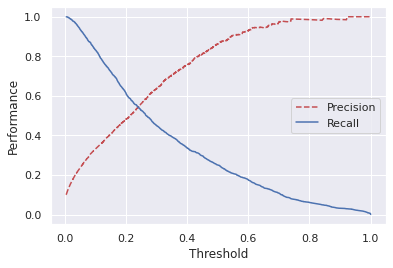

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc='best')

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.2434814

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.35780033792946275,
  "recall": 0.31929046563192903,
  "f1": 0.305017403121047
}


# Transformer Model

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
X_test_raw = X_test

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

print (device)

cuda


In [ ]:
# tokenizers
!pip install transformers

In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer

In [ ]:
# load tokenizer model
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vocab_size = len(tokenizer)
print(vocab_size)


31090


In [ ]:
# Tokenizer inputs
encoded_input = tokenizer(X_train.tolist(), return_tensors="pt", padding=True)
X_train_ids = encoded_input["input_ids"]
X_train_masks = encoded_input["attention_mask"]
print(X_train_ids.shape, X_train_masks.shape)
encoded_input = tokenizer(X_val.tolist(), return_tensors="pt", padding=True)
X_val_ids = encoded_input["input_ids"]
X_val_masks = encoded_input["attention_mask"]
print(X_val_ids.shape, X_val_masks.shape)
encoded_input = tokenizer(X_test.tolist(), return_tensors="pt", padding=True)
X_test_ids = encoded_input["input_ids"]
X_test_masks = encoded_input["attention_mask"]
print(X_test_ids.shape, X_test_masks.shape)

torch.Size([1023, 40]) torch.Size([1023, 40])
torch.Size([205, 37]) torch.Size([205, 37])
torch.Size([216, 41]) torch.Size([216, 41])


In [ ]:
# Decode
print (f"{X_train_ids[0]}\n{tokenizer.decode(X_train_ids[0])}")

tensor([  102,   605,  1414,  1934,  3267,  7566,   776,  4220, 15820, 30126,
          103,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
[CLS] medacy medical text mining information extraction spacy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# Sub-word tokens
print (tokenizer.convert_ids_to_tokens(ids=X_train_ids[0]))

['[CLS]', 'med', '##acy', 'medical', 'text', 'mining', 'information', 'extraction', 'spac', '##y', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print ("class counts:\n"
    f"  {counts}\n\n"
    "class weights:\n"
    f"  {class_weights}")

class counts:
  [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39  39]

class weights:
  {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564, 34: 0.0256410256410

In [ ]:
class TransformerTextDataset(torch.utils.data.Dataset):
    def __init__(self, ids, masks, targets):
        self.ids = ids
        self.masks = masks
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __str__(self):
        return f"<Dataset(N={len(self)})"

    def __getitem__(self, index):
        ids = torch.tensor(self.ids[index], dtype=torch.long)
        masks = torch.tensor(self.masks[index], dtype=torch.long)
        targets = torch.FloatTensor(self.targets[index])
        return ids, masks, targets

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=False)

In [ ]:
# Create datasets
train_dataset = TransformerTextDataset(ids=X_train_ids, masks=X_train_masks, targets=y_train)
val_dataset = TransformerTextDataset(ids=X_val_ids, masks=X_val_masks, targets=y_val)
test_dataset = TransformerTextDataset(ids=X_test_ids, masks=X_test_masks, targets=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  ids: {train_dataset[0][0]}\n"
    f"  masks: {train_dataset[0][1]}\n"
    f"  targets: {train_dataset[0][2]}")

Data splits:
  Train dataset:<Dataset(N=1023)
  Val dataset: <Dataset(N=205)
  Test dataset: <Dataset(N=216)
Sample point:
  ids: tensor([  102,   605,  1414,  1934,  3267,  7566,   776,  4220, 15820, 30126,
          103,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
  masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  targets: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cpu')


In [ ]:
# Create dataloaders
batch_size = 128
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  ids: {batch[0].size()}\n"
    f"  masks: {batch[1].size()}\n"
    f"  targets: {batch[2].size()}")

Sample batch:
  ids: torch.Size([128, 40])
  masks: torch.Size([128, 40])
  targets: torch.Size([128, 35])


In [ ]:
from transformers import BertModel

In [ ]:
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, dropout_p, embedding_dim, num_classes):
        super(Transformer, self).__init__()
        self.transformer = transformer
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        ids, masks = inputs
        seq, pool = self.transformer(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

In [ ]:
# Initialize model
dropout_p = 0.5
model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
# Arguments
lr = 1e-4
num_epochs = 200
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00871, val_loss: 0.00546, lr: 1.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.00475, val_loss: 0.00367, lr: 1.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.00353, val_loss: 0.00312, lr: 1.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.00314, val_loss: 0.00295, lr: 1.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.00300, val_loss: 0.00290, lr: 1.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.00296, val_loss: 0.00289, lr: 1.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.00293, val_loss: 0.00289, lr: 1.00E-04, _patience: 9
Epoch: 8 | train_loss: 0.00295, val_loss: 0.00289, lr: 1.00E-04, _patience: 8
Epoch: 9 | train_loss: 0.00293, val_loss: 0.00289, lr: 1.00E-04, _patience: 7
Epoch: 10 | train_loss: 0.00292, val_loss: 0.00289, lr: 1.00E-04, _patience: 10
Epoch: 11 | train_loss: 0.00293, val_loss: 0.00289, lr: 1.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.00293, val_loss: 0.00289, lr: 1.00E-04, _patience: 9
Epoch: 13 | train_loss: 0.00294, val_loss: 0.00289, l

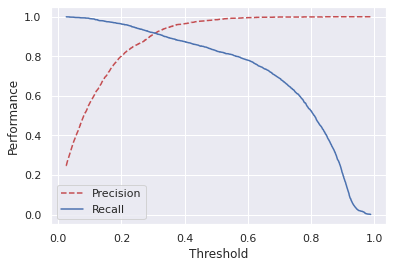

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc='best')

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.36956012

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8072169859891675,
  "recall": 0.6208425720620843,
  "f1": 0.6844217478060112
}


In [ ]:
# Save artifacts
dir = Path("transformers")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Load artifacts
device = torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size
model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device);

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = preprocess(text)
encoded_input = tokenizer(X, return_tensors="pt", padding=True).to(torch.device("cpu"))
ids = encoded_input["input_ids"]
masks = encoded_input["attention_mask"]
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]] * len(X))])
dataset = TransformerTextDataset(ids=ids, masks=masks, targets=y_filler)
dataloader = dataset.create_dataloader(batch_size=int(batch_size))

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

[['transfer-learning']]

# Visualize attention

In [ ]:
import sys
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not "bertviz_repo" in sys.path:
    sys.path += ["bertviz_repo"]

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1416, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1416 (delta 137), reused 133 (delta 71), pack-reused 1203
Receiving objects: 100% (1416/1416), 213.85 MiB | 26.88 MiB/s, done.
Resolving deltas: 100% (900/900), done.


In [ ]:
from bertviz import head_view

In [ ]:
print(ids)
print(tokenizer.batch_decode(ids))

tensor([[  102,  2268,  1904, 24921,  1968, 13749,  1904,   103]],
       device='cpu')
['[CLS] transfer learning bert self supervised learning [SEP]']


In [ ]:
# Get encoder attentions
seq, pool, attn = model.transformer(input_ids=ids, attention_mask=masks, output_attentions=True)

In [ ]:
print(len(attn))
print(attn[0].shape)

12
torch.Size([1, 12, 8, 8])


In [ ]:
# HTML set up
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
# Visualize self-attention weights
call_html()
tokens = tokenizer.convert_ids_to_tokens(ids[0])
head_view(attention=attn, tokens=tokens)

<IPython.core.display.Javascript object>

In [ ]:
# Performance
with open(Path("cnn", "performance.json"), "r") as fp:
    cnn_performance = json.load(fp)
with open(Path("transformers", "performance.json"), "r") as fp:
    transformers_performance = json.load(fp)
print (f'CNN: f1 = {cnn_performance["f1"]}')
print (f'Transformer: f1 = {transformers_performance["f1"]}')

CNN: f1 = 0.6231184058987846
Transformer: f1 = 0.6844217478060112


In [ ]:
# Size
print (f'CNN: {Path("cnn", "model.pt").stat().st_size/1000000:.1f} MB')
print (f'Transformer: {Path("transformers", "model.pt").stat().st_size/1000000:.1f} MB')

CNN: 4.3 MB
Transformer: 439.9 MB


In [ ]:
print (f'CNN: {Path(dir, "model.pt").stat().st_size/1000000:.1f} MB')

CNN: 4.3 MB


In [ ]:
metrics = {"overall": {}, "class": {}}

In [ ]:
# data to evaluate
print(f"Device: {device}")
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
trainer = Trainer(model=model.to(device), device=device, loss_fn=loss_fn)
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

Device: cpu


In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_true))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.7774170799471126,
    "recall": 0.5521064301552107,
    "f1": 0.6231184058987846,
    "num_samples": 216.0
}


In [ ]:
# Per class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i])
    }

In [ ]:
tag = "transformers"
print(json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.8571428571428571,
  "recall": 0.6206896551724138,
  "f1": 0.7200000000000001,
  "num_samples": 29.0
}


# Confusion Matric
- True positives: learn about where our model performs well.
- False positives: potentially identify samples which may need to be relabeled.
- False negatives: identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP and FN samples
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i in range(len(y_test)):
    true = y_test[i][index]
    pred = y_pred[i][index]
    if true and pred:
        tp.append(i)
    elif not true and pred:
        fp.append(i)
    elif true and not pred:
        fn.append(i)

In [ ]:
print(tp)
print(fp)
print(fn)

[15, 19, 31, 47, 53, 81, 114, 123, 132, 165, 166, 169, 173, 176, 179, 182, 196, 202]
[89, 93, 144]
[22, 34, 64, 65, 68, 92, 151, 184, 192, 204, 205]


In [ ]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}\n")

fasthugs sequence classification transformers fastai fine tune text classification model huggingface transformers fastai v2
true: ['huggingface', 'natural-language-processing', 'transformers']
pred: ['attention', 'huggingface', 'natural-language-processing', 'transformers']



In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))

In [ ]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag='transformers'):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))
    
    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i in range(len(y_test)):
        true = y_test[i][index]
        pred = y_pred[i][index]
        if true and pred:
            tp.append(i)
        elif not true and pred:
            fp.append(i)
        elif true and not pred:
            fn.append(i)
            
    # Samples
    num_samples = 3
    if len(tp): 
        print ("\n=== True positives ===")
        for i in tp[:num_samples]:        
            print (f"  {X_test_raw[i]}")
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")
    if len(fp): 
        print ("=== False positives === ")
        for i in fp[:num_samples]:        
            print (f"  {X_test_raw[i]}")
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")
    if len(fn): 
        print ("=== False negatives ===")
        for i in fn[:num_samples]:        
            print (f"  {X_test_raw[i]}") 
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")

interactive(children=(Dropdown(description='tag', index=12, options=('node-classification', 'graphs', 'graph-n…

In [ ]:
# Slicing function
# To evaluate your model which expect to perform really well on key data points
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def cv_transformers(x):
    """Projects with the `computer-vision` and `transformers` tags."""
    return all(tag in x.tags for tag in ["computer-vision", "transformers"])

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 7  # less than 7 words

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tags"]].head()

100%|██████████| 216/216 [00:00<00:00, 19940.78it/s]


,text,tags
25,gpflow gaussian processes tensorflow,[tensorflow]
26,biosyn biomedical entity representations synon...,[natural-language-processing]
39,deeprecommender training deep autoencoders col...,"[autoencoders, pytorch]"
60,captum model interpretability pytorch,"[interpretability, pytorch]"
62,clustering algorithms look different types clu...,[unsupervised-learning]


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/v0.9.6/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
slicing_functions = [cv_transformers, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 216/216 [00:00<00:00, 13332.69it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [ ]:
# Score slices
metrics["slices"] = {}
metrics["slices"]["class"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"]["class"][slice_name] = {}
        metrics["slices"]["class"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"]["class"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"]["class"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"]["class"][slice_name]["num_samples"] = len(y_true[mask])

In [ ]:
# Weighted overall slice metrics
metrics["slices"]["overall"] = {}
for metric in ["precision", "recall", "f1"]:
    metrics["slices"]["overall"][metric] = np.mean(
        list(
            itertools.chain.from_iterable(
                [
                    [metrics["slices"]["class"][slice_name][metric]]
                    * metrics["slices"]["class"][slice_name]["num_samples"]
                    for slice_name in metrics["slices"]["class"]
                ]
            )
        )
    )

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

{
  "class": {
    "cv_transformers": {
      "precision": 1.0,
      "recall": 0.4666666666666667,
      "f1": 0.6363636363636364,
      "num_samples": 3
    },
    "short_text": {
      "precision": 0.5714285714285714,
      "recall": 0.75,
      "f1": 0.6486486486486486,
      "num_samples": 11
    }
  },
  "overall": {
    "precision": 0.6632653061224489,
    "recall": 0.6892857142857143,
    "f1": 0.646016146016146
  }
}


In [ ]:
!pip install mlflow

     |████████████████████████████████| 14.6 MB 84 kB/s 
     |████████████████████████████████| 170 kB 43.8 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 636 kB 43.1 MB/s 
     |████████████████████████████████| 146 kB 45.3 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=e6be9b3c6110a76aa529fe24d81bf9fa63854b806a21af1fc33d1dca6adac3fd
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=405914034c3feeda8749c58caecc26e280068d731139147bdbe7a107182b47f4

In [ ]:
from argparse import Namespace
import mlflow
from pathlib import Path

In [ ]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 5.3 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=a9e995ef059a930ddb00d93cfd523032d2a1314af236a9f8728d9ceea3482500
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
mlflow.set_experiment("baselines")

INFO: 'baselines' does not exist. Creating a new experiment


In [ ]:
# Specify arguments
args = Namespace(
    char_level=True,
    filter_sizes=list(range(1, 11)),
    batch_size=64,
    embedding_dim=128, 
    num_filters=128,
    hidden_dim=128, 
    dropout_p=0.5,
    lr=2e-4,
    num_epochs=200,
    patience=10,
)

> When we move to Python scripts, we'll use the [Typer](https://typer.tiangolo.com/) package instead of argparse for a better CLI experience.

In [ ]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [ ]:
!ls

drive  experiments  mlruns  sample_data


### Training

We're going to log the training epoch metrics within our `Trainer`'s `train` function. 

In [ ]:
# Trainer (modified for experiment tracking)
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, 
                 optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):
            # Step
            batch = [item.to(self.device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Tracking
            mlflow.log_metrics(
                {"train_loss": train_loss, "val_loss": val_loss}, step=epoch
            )

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )

        return best_model, best_val_loss

And to make things simple, we'll encapsulate all the components for training into one function which returns all the artifacts we want to be able to track from our experiment. The input argument `args`contains all the parameters needed and it's nice to have it all organized under one variable so we can easily log it and tweak it for different experiments (we'll see this when we do hyperparameter optimization).

In [ ]:
def train_cnn(args, df):
    """Train a CNN using specific arguments."""

    # Set seeds
    set_seeds()

    # Get data splits
    preprocessed_df = df.copy()
    preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
    num_classes = len(label_encoder)

    # Set device
    cuda = True
    device = torch.device("cuda" if (
        torch.cuda.is_available() and cuda) else "cpu")
    torch.set_default_tensor_type("torch.FloatTensor")
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.FloatTensor")

    # Tokenize
    tokenizer = Tokenizer(char_level=args.char_level)
    tokenizer.fit_on_texts(texts=X_train)
    vocab_size = len(tokenizer)

    # Convert texts to sequences of indices
    X_train = np.array(tokenizer.texts_to_sequences(X_train))
    X_val = np.array(tokenizer.texts_to_sequences(X_val))
    X_test = np.array(tokenizer.texts_to_sequences(X_test))

    # Class weights
    counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
    class_weights = {i: 1.0/count for i, count in enumerate(counts)}

    # Create datasets
    train_dataset = CNNTextDataset(
        X=X_train, y=y_train, max_filter_size=max(args.filter_sizes))
    val_dataset = CNNTextDataset(
        X=X_val, y=y_val, max_filter_size=max(args.filter_sizes))
    test_dataset = CNNTextDataset(
        X=X_test, y=y_test, max_filter_size=max(args.filter_sizes))

    # Create dataloaders
    train_dataloader = train_dataset.create_dataloader(
        batch_size=args.batch_size)
    val_dataloader = val_dataset.create_dataloader(
        batch_size=args.batch_size)
    test_dataloader = test_dataset.create_dataloader(
        batch_size=args.batch_size)

    # Initialize model
    model = CNN(
        embedding_dim=args.embedding_dim, vocab_size=vocab_size,
        num_filters=args.num_filters, filter_sizes=args.filter_sizes,
        hidden_dim=args.hidden_dim, dropout_p=args.dropout_p,
        num_classes=num_classes)
    model = model.to(device)

    # Define loss
    class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
    loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    # Define optimizer & scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5)

    # Trainer module
    trainer = Trainer(
        model=model, device=device, loss_fn=loss_fn, 
        optimizer=optimizer, scheduler=scheduler)

    # Train
    best_model, best_val_loss = trainer.train(
        args.num_epochs, args.patience, train_dataloader, val_dataloader)

    # Best threshold for f1
    train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
    precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
    threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())

    # Determine predictions using threshold
    test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
    y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

    # Evaluate (simple)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

    return {
        "args": args,
        "tokenizer": tokenizer,
        "label_encoder": label_encoder,
        "model": best_model,
        "performance": performance,
        "best_val_loss": best_val_loss,
    }

### Tracking

With MLFlow we need to first initialize an experiment and then you can do runs under that experiment.

In [ ]:
!pip install PyYAML==5.4.1

In [ ]:
import tempfile

In [ ]:
# # Set experiment
# mlflow.set_experiment(experiment_name="baselines")

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Tracking
with mlflow.start_run(run_name="cnn") as run:

    # Train & evaluate
    artifacts = train_cnn(args=args, df=df)    
    
    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["overall"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["overall"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["overall"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["tokenizer"].save(Path(dp, "tokenizer.json"))
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        torch.save(artifacts["model"].state_dict(), Path(dp, "model.pt"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

MlflowException: ignored